In [1]:
cd ..

/Users/hyunminhong/Kalman-Heston-Filter


In [2]:
from src.Utility import Utility, MeasurementType
from src.KalmanFilterSV import HestonKalmanFilter
from src.KalmanFilterCorr import HestonKalmanFilterCorr
from src.ParticleFilter import PFHeston
from src.RealizedGARCH import RealizedGARCH
from src.Heston import *
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [3]:
# Set initial conditions and simulation parameters
S0 = 100
V0 = 0.04
params = {
    'mu': 0.05,
    'rho': -0.8,
    'kappa': 5.0,
    'theta': 0.04,
    'xi': 0.35
}
std_asy = np.sqrt(params['theta'] * params['xi']**2 / (2 * params['kappa']))
feller_cond = 2 * params['kappa'] * params['theta'] / params['xi']**2
print(round(feller_cond, 2))
assert feller_cond > 1, "Feller condition is violated!"

Hest = Heston(**params)
time_daily, S_daily, daily_returns, daily_true_V, daily_RV = Hest.path_simulation(
    S0, V0, T_years=10, trading_days=252, intraday_intervals=39, seed=40
)
R_daily = daily_returns.copy()

3.27


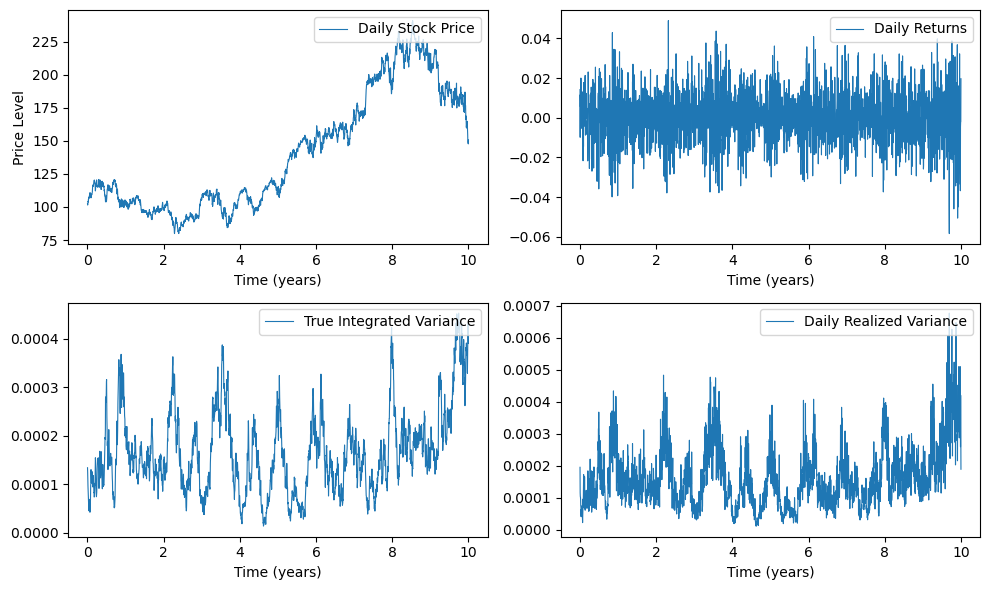

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Subplot for BOTH measurements
axes[0,0].plot(time_daily, S_daily, label="Daily Stock Price", lw=0.8)
axes[0,0].set_xlabel("Time (years)")
axes[0,0].set_ylabel("Price Level")
axes[0,0].legend(loc="upper right")

# Subplot for RETURNS measurement
axes[0,1].plot(time_daily, daily_returns, label="Daily Returns", lw=0.8)
axes[0,1].set_xlabel("Time (years)")
axes[0,1].legend(loc="upper right")

# Subplot for RV measurement
axes[1,0].plot(time_daily, daily_true_V, label="True Integrated Variance", lw=0.8)
axes[1,0].set_xlabel("Time (years)")
axes[1,0].legend(loc="upper right")

# Subplot for RV measurement
axes[1,1].plot(time_daily, daily_RV, label="Daily Realized Variance", lw=0.8)
axes[1,1].set_xlabel("Time (years)")
axes[1,1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [5]:
burnin = 252
dt = 1  # Daily

split_index = 6 * 252 

# TRAINING SET 
train_returns = daily_returns[:split_index]
train_RV = daily_RV[:split_index]

# TEST SET 
test_returns = daily_returns[split_index:]
test_RV = daily_RV[split_index:]

### Both - Corr

In [22]:
hkf_both_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both_corr.set_data(returns=train_returns, rv=train_RV)
initial_params_both_corr = np.array([0.05, 0.0001, 0.001, 0.001, 0.001, -0.2])
# initial_params_both_corr = np.array([0.1, 0.01, 0.01, 0.001, 0.001, -0.1])

fit_results_both_corr = hkf_both_corr.fit(initial_params=initial_params_both_corr, burnin=burnin)
params_opt_both_corr = fit_results_both_corr['params']
print("Optimized parameters (BOTH):", params_opt_both_corr)

train_result_both_corr = hkf_both_corr.filter(params_opt_both_corr)
last_V_train_corr = train_result_both_corr['V_filt'][-1]
last_P_train_corr = train_result_both_corr['P_filt'][-1]

hkf_both_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train_corr, P0=last_P_train_corr)
test_result_both_corr = hkf_both_test_corr.filter(params=params_opt_both_corr, returns=test_returns, rv=test_RV)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.40740D+04    |proj g|=  3.44863D+05

At iterate    1    f= -1.40768D+04    |proj g|=  7.63860D+02

At iterate    2    f= -1.40772D+04    |proj g|=  2.38825D+03

At iterate    3    f= -1.40772D+04    |proj g|=  2.59835D+03

At iterate    4    f= -1.40772D+04    |proj g|=  4.91351D+03

At iterate    5    f= -1.40773D+04    |proj g|=  2.14000D+04

At iterate    6    f= -1.40773D+04    |proj g|=  4.13522D+04

At iterate    7    f= -1.40775D+04    |proj g|=  7.36186D+04

At iterate    8    f= -1.40778D+04    |proj g|=  1.09062D+05

At iterate    9    f= -1.40784D+04    |proj g|=  1.23275D+05

At iterate   10    f= -1.40789D+04    |proj g|=  8.93616D+04

At iterate   11    f= -1.40792D+04    |proj g|=  2.48560D+04

At iterate   12    f= -1.40793D+04    |proj g|=  7.89988D-01

At iterate   13    f= -1.4

### Return - Corr

In [65]:
# Fit the model using training data
hkf_returns_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.02, P0=0.1)
hkf_returns_corr.set_data(returns=train_returns)
initial_params_returns_corr = np.array([0.002, 0.0001, 0.007, 0.002, -0.05])

fit_results_returns_corr = hkf_returns_corr.fit(initial_params=initial_params_returns_corr, burnin=burnin)
params_opt_returns_corr = fit_results_returns_corr['params']
print("Optimized parameters (RETURNS):", params_opt_returns_corr)

train_result_returns_corr = hkf_returns_corr.filter(params_opt_returns_corr)
last_V_returns_corr = train_result_returns_corr['V_filt'][-1]
last_P_returns_corr = train_result_returns_corr['P_filt'][-1]

hkf_returns_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns_corr, P0=last_P_returns_corr)
test_result_returns_corr = hkf_returns_test_corr.filter(params=params_opt_returns_corr, returns=test_returns)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.44834D+03    |proj g|=  1.85896D+05

At iterate    1    f= -3.21093D+03    |proj g|=  1.22532D+07

At iterate    2    f= -3.33882D+03    |proj g|=  2.12908D+01

At iterate    3    f= -3.73318D+03    |proj g|=  5.71859D+01

At iterate    4    f= -3.73352D+03    |proj g|=  6.22748D+01

At iterate    5    f= -3.73353D+03    |proj g|=  6.59663D+03

At iterate    6    f= -3.73362D+03    |proj g|=  4.52827D+04

At iterate    7    f= -3.73382D+03    |proj g|=  1.00121D+05

At iterate    8    f= -3.73438D+03    |proj g|=  2.00221D+05

At iterate    9    f= -3.73590D+03    |proj g|=  3.74283D+05

At iterate   10    f= -3.74078D+03    |proj g|=  7.25116D+05

At iterate   11    f= -3.74215D+03    |proj g|=  1.05824D+06

At iterate   12    f= -3.76531D+03    |proj g|=  1.51509D+06
  Positive dir derivative i


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f= -3.81442D+03    |proj g|=  4.00768D+03

At iterate   31    f= -3.81442D+03    |proj g|=  4.47635D+03

At iterate   32    f= -3.81442D+03    |proj g|=  1.06129D+02

At iterate   33    f= -3.81442D+03    |proj g|=  8.27617D+00

QMLE Results for Heston Model:
At iterate   34    f= -3.81442D+03    |proj g|=  8.27599D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34    126     42     0     0   8.276D+00  -3.814D+03
  F =  -3814.4205339165596     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

--------------------------------------------------
kappa: 0.023186
theta: 0.00015


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


### PF

In [17]:
pf_heston_train = PFHeston(train_returns, N=10000, dt=1/252, is_log=True)

param_bounds_train = [
    (-0.1, 0.1),    # mu
    (1, 5),        # kappa
    (0.02, 0.03),    # theta
    (0.1, 0.3),    # xi
    (-0.9, 0),        # rho
    V0              # v0
]

_, estimated_param = pf_heston_train.filter(param_bounds_train, predict_obs=False)
param_bounds = list(zip(estimated_param[:,-1] - 1e-3, estimated_param[:,-1] + 1e-3))

resampling since: 1989.1721522450423
resampling since: 998.6897235018067
resampling since: 5439.036384361168
resampling since: 3048.1319275614605
resampling since: 128.85564894005398
resampling since: 3021.0981594818404
resampling since: 3800.8287937122955
resampling since: 1785.7999048581023
resampling since: 2445.178605871864
resampling since: 5655.121141813509
resampling since: 5654.319523962273
resampling since: 6261.782499881973
resampling since: 1269.2838512899116
resampling since: 5984.234301915575
resampling since: 424.2545305019898
resampling since: 290.346526928376
resampling since: 5734.781959929941
resampling since: 3710.217147992396
resampling since: 371.50223875799594
resampling since: 1332.0088853780144
resampling since: 4671.770675335983
resampling since: 6399.680180123311
resampling since: 6478.858986140597
resampling since: 5770.8723329257455
resampling since: 6939.506492901372
resampling since: 1613.155641583526
resampling since: 430.96665290791435
resampling since: 

In [18]:
pf_heston_test = PFHeston(test_returns, N=10000, dt=1/252, is_log=True)

V_pf_train, _ = pf_heston_train.filter([*param_bounds, V0], predict_obs=False)
V_pf_test, _ = pf_heston_test.filter([*param_bounds, V_pf_train[-1]], predict_obs=False)

resampling since: 5716.657822261723
resampling since: 6924.013468223377
resampling since: 6701.631491015673
resampling since: 6328.8885470886635
resampling since: 6568.993664647576
resampling since: 5939.43944706546
resampling since: 3591.908830628352
resampling since: 5012.100018443787
resampling since: 6898.944509295611
resampling since: 6475.29284415617
resampling since: 6579.017718835394
resampling since: 6744.093241669169
resampling since: 5691.1333137110805
resampling since: 6424.144529670906
resampling since: 6376.284961473322
resampling since: 2802.6118211803887
resampling since: 6678.716044942711
resampling since: 5429.431791826636
resampling since: 4597.610235525474
resampling since: 5702.05789365197
resampling since: 6980.960619789618
resampling since: 4912.901600512065
resampling since: 6659.094195345472
resampling since: 2646.6098837731633
resampling since: 3949.7152865517955
resampling since: 6718.993294938085
resampling since: 6828.430416214675
resampling since: 6887.805

In [19]:
V_pf_train_daily = V_pf_train / 400
V_pf_test_daily = V_pf_test / 400

### Realized GARCH

In [20]:
# Fit the model
model = RealizedGARCH(p=1, q=1)
model.fit(train_returns, train_RV)

# Get fitted volatility (in-sample)
fitted_vol = model.get_fitted_volatility(train_returns, train_RV)

# Predict volatility (out-of-sample)
predicted_vol = model.predict(test_returns, test_RV)

## Plot

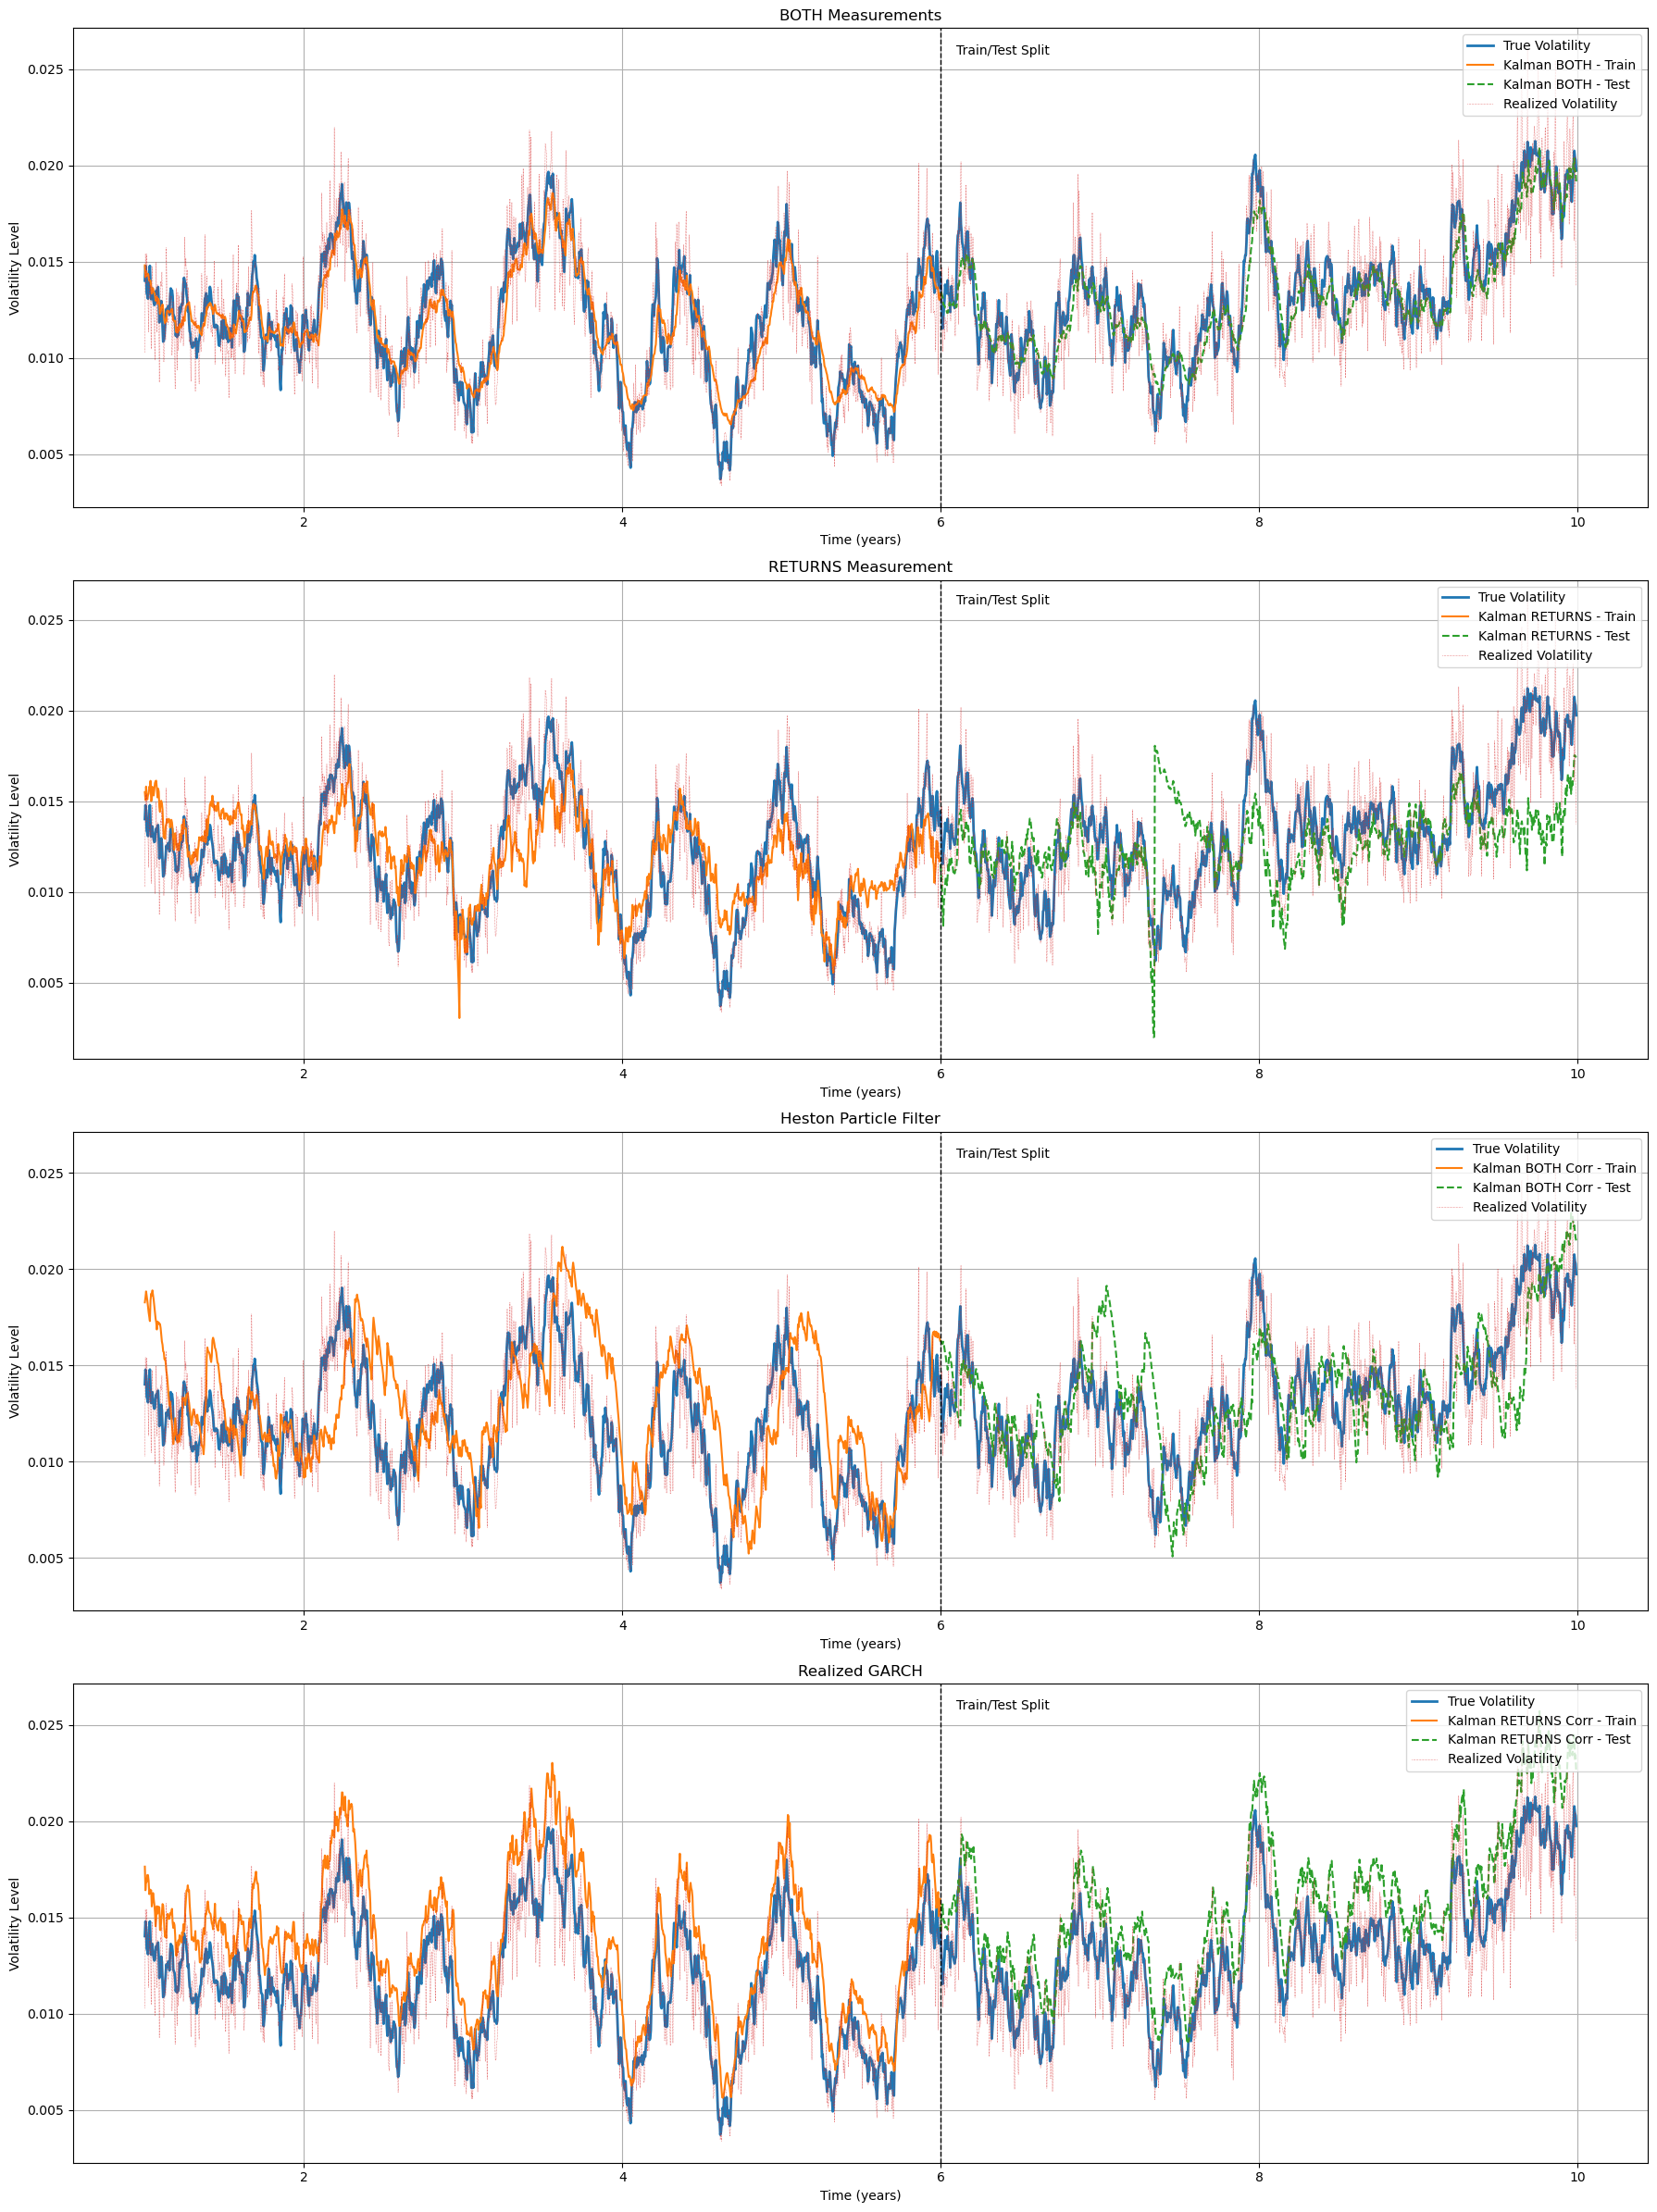

In [66]:
v_item = 'V_pred'

titles_all = ["BOTH Measurements", "RETURNS Measurement", "Heston Particle Filter", "Realized GARCH"]
labels_all = ["Kalman BOTH", "Kalman RETURNS", "Kalman BOTH Corr", "Kalman RETURNS Corr", "PF Heston", "Realized GARCH"]
train_all = [train_result_both_corr[v_item], train_result_returns_corr[v_item], V_pf_train_daily, fitted_vol]
test_all = [test_result_both_corr[v_item], test_result_returns_corr[v_item], V_pf_test_daily, predicted_vol]

Utility.plot_all_filters(
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=252, 
    save_path=r"./output/base.png"
)

In [67]:
def qlike_loss(true_var, pred_var):
    y = np.asarray(true_var)
    h = np.asarray(pred_var)
    
    eps = np.finfo(float).eps
    ratio = y / (h + eps)
    return np.mean(ratio - np.log(ratio) - 1)

model_names = ['QLKF (Both)', 'QLKF (Return)', 'PF', 'Realized GARCH']
true_variances   = daily_true_V[split_index:]
true_volatilities = np.sqrt(true_variances)

mae_scores   = {}
rmse_scores  = {}
qlike_scores = {}

for name, pred_var in zip(model_names, np.array(test_all).clip(1e-9, None)):
    pred_vol = np.sqrt(pred_var)
    
    mae_scores[name]   = mean_absolute_error(true_volatilities, pred_vol)
    rmse_scores[name]  = np.sqrt(mean_squared_error(true_volatilities, pred_vol))
    qlike_scores[name] = qlike_loss(true_variances, pred_var)

print("Results:")
for name in model_names:
    print(f"{name:18s} RMSE: {rmse_scores[name]:.6f}, "
          f"QLIKE: {qlike_scores[name]:.6f}")

Results:
QLKF (Both)        RMSE: 0.001168, QLIKE: 0.017434
QLKF (Return)      RMSE: 0.003098, QLIKE: 0.133551
PF                 RMSE: 0.002638, QLIKE: 0.087618
Realized GARCH     RMSE: 0.002673, QLIKE: 0.058768


In [70]:
data = {}

data['QLKF (Both)'] = dict(zip(
    ['kappa', 'theta', 'xi', 'mu', 'sigma', 'rho'],
    params_opt_both_corr
))

data['QLKF (Return)'] = dict(zip(
    ['kappa', 'theta', 'xi', 'mu', 'rho'],
    params_opt_returns_corr
))
data['QLKF (Both)']['sigma'] = np.nan

pf_vals = estimated_param[:, -1]
data['PF'] = {
    'kappa': pf_vals[1],
    'theta': pf_vals[2],
    'xi':    pf_vals[3],
    'mu':    pf_vals[0],
    'rho':   pf_vals[4],
    'sigma': np.nan
}

cols = ['kappa', 'theta', 'xi', 'mu', 'sigma', 'rho']
df_params = pd.DataFrame.from_dict(data, orient='index')[cols]

df_params.T

,QLKF (Both),QLKF (Return),PF
kappa,0.012998,0.023186,1.390855
theta,0.000128,0.000153,0.026225
xi,0.000856,0.007200,0.296591
mu,0.000431,0.000125,-0.011179
sigma,NaN,NaN,NaN
rho,-0.206413,-0.049909,-0.288722


In [74]:
dict(zip(model.param_names, model.params))

{'omega': 0.009537847299027326,
 'beta': 0.7843773208838261,
 'gamma': 0.20704277882358374,
 'xi': -0.5015857310184896,
 'phi': 0.9347783967072548,
 'tau_1': 0.07382564019669213,
 'tau_2': 0.003399606193951542,
 'sigma_u': 0.24220129434056892,
 'sigma_z': 1.0}